# Tutorial: Measurement Control - adaptive sampling

Author(s): Victor Negîrneac

Last update: 2020-03-25

This is an advanced tutorial that focuses on adaptive sampling. If you are new to `PycQED` measurements and mesurements flow control, take a look first at `PycQED_py3/examples/MeasurementControl.ipynb`. It covers the basics of measurement control, soft(ware) and hard(ware) measurements, etc..

### Contents covered in this notebook
We can mix `soft`(ware) and `hard`(ware) measurements but for simplicity this notebook focuses on the `soft` measurements. In the "normal" `soft` (vs "adaptive" `soft`) measurements `MC` is in charge of the measurement loop and consecutively sets and gets datapoints according to a **pre-determined** list of points, usually a rectangular-like regular grid (i.e. uniform sampling in each dimension).

On the other hand, for an `adaptive` measurment the datapoints are determined dynamically during the measurement loop itself. Any optimization falls into this case. Furthermore, here we focus on `soft adaptive` measurements. (I would call `hard adaptive` a sampling algorithm running on an FPGA.)

This tutorial is structured in the following way, a sampling problem is stated and a possible solution based on adaptive sampling is shown to highlight the available features. We will start with a few uniform sampling examples to showcase the advatages provided by the adaptive sampling approach.

## Future reproducibility of this notebook
`PycQED` and its dependencies are a rapidly evolving repositories therefore this notebook might stop working properly with the latest packages at any moment in the future. In order to always be able to reproduce this notebook, below you can find the software versions used in this tutorial as well as the commit hash of `PycQED` at the moment of writing.

#### NB: if you run the two cells below you will have to git reset the file to get the original output back

In [17]:
from pycqed.utilities import git_utils as gu

print_output = True
pycqed_path = pq.__path__[0]
#status_pycqed, _ = gu.git_status(repo_dir=pycqed_path, print_output=print_output)
last_commit_pycqed, _ = gu.git_get_last_commit(repo_dir=pycqed_path, author=None, print_output=print_output)

from platform import python_version
python_v = python_version()

ipython_v = !ipython --version
jupyterlab_v = !jupyter-lab --version

print()
print("Python version: ", python_v)
print("iPython version: ", ipython_v[0])
print("Jupyter Lab version: ", jupyterlab_v[0])


GIT LAST COMMIT
STDOUT:
commit 71192503f44ac91336678385899416a2a20398d5
Merge: aed665f8 4ec36a56
Author: caenrigen <31376402+caenrigen@users.noreply.github.com>
Date:   Fri Mar 20 21:52:57 2020 +0100

    Merge remote-tracking branch 'origin/develop' into develop

STDERROR:
None

Python version:  3.7.6
iPython version:  7.12.0
Jupyter Lab version:  1.2.6


In [18]:
# In case you are not able to run this notebook you can setup a virtual env with the following pacakges

!pip list

Package             Version              Location                                                           
------------------- -------------------- -------------------------------------------------------------------
adaptive            0.10.0               
appdirs             1.4.3                
applicationinsights 0.11.9               
appnope             0.1.0                
asteval             0.9.18               
atomicwrites        1.3.0                
attrs               19.3.0               
autodepgraph        0.3.4                
backcall            0.1.0                
black               19.10b0              
bleach              3.1.1                
certifi             2019.11.28           
chardet             3.0.4                
Click               7.0                  
cma                 2.7.0                
cycler              0.10.0               
Cython              0.29.15              
decorator           4.4.1                
defusedxml          0.6.0 

## Import required modules

In [1]:
%matplotlib inline
import adaptive
import matplotlib.pyplot as plt
import pycqed as pq
import numpy as np
from pycqed.measurement import measurement_control as mc
#from pycqed.measurement.sweep_functions import None_Sweep
#import pycqed.measurement.detector_functions as det

from qcodes import station
station = station.Station()

import pycqed.analysis_v2.measurement_analysis as ma2

from importlib import reload
from pycqed.utilities.general import print_exception

/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Data directory set to: /Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Could not import msvcrt (used for detecting keystrokes)
/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Data directory set to: /Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Data directory set to: /Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Data directory set to: /Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
/Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data
Data directory set to: /Users/Victor/Documents/ProjectsDev/DiCarloLab-Delft/PycQED_py3/data


## Creating an instance of `MeasurementControl`

In [2]:
MC = mc.MeasurementControl('MC',live_plot_enabled=True, verbose=True)
MC.station = station
station.add_component(MC)

MC.persist_mode(True) # Turns on and off persistent plotting from previous run
MC.verbose(True)
MC.plotting_interval(.4)
MC.live_plot_enabled(True)

## Create instruments used in the experiment 
We will use a dummy instrument behaving like a Chevron measurement

In [13]:
import pycqed.instrument_drivers.physical_instruments.dummy_instruments as di
reload(di)

intr_name = "dummy_chevron"
if intr_name in station.components.keys():
    # Reset instr if it exists from previously running this cell
    station.close_and_remove_instrument(intr_name)
    del dummy_chevron
    
dummy_chevron = di.DummyChevronAlignmentParHolder(intr_name)
station.add_component(dummy_chevron)

'dummy_chevron'

## **Problem:** How to observe the features of a 1D function with the minimum number of sampling points?

### Simple 1D uniform sweep

Starting measurement: 1D uniform
Sweep function: amp
Detector function: frac_excited
 100% completed 	elapsed time: 0.8s 	time left: 0.0s


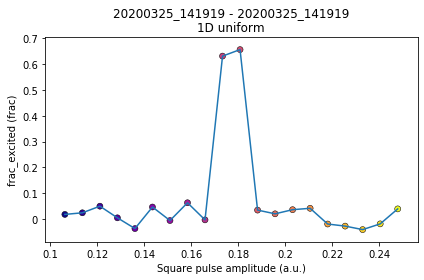

In [14]:
dummy_chevron.delay(.001)
dummy_chevron.noise(0.05)
dummy_chevron.t(20e-9)
dummy_chevron.detuning_swt_spt(12.5e9)

npoints = 20
bounds = [0.6 * dummy_chevron.amp_center_2(), 1.4 * dummy_chevron.amp_center_2()]

MC.soft_avg(1)
MC.set_sweep_function(dummy_chevron.amp)
MC.set_sweep_points(np.linspace(bounds[0], bounds[-1], npoints))

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D uniform'
dat = MC.run(label, mode="1D")
ma2.Basic1DAnalysis(label=label, close_figs=False)

### Adaptive 1D sampling

Starting measurement: 1D adaptive
Sweep function: amp
Detector function: frac_excited
Acquired 20 points, 	elapsed time: 3.1s

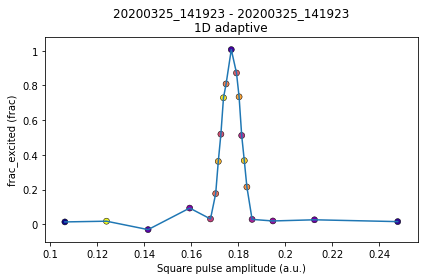

In [15]:
MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': adaptive.Learner1D,
    'bounds': bounds,
    'goal': lambda l: l.npoints >= npoints
    })

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D adaptive'
dat = MC.run(label, mode="adaptive")
ma2.Basic1DAnalysis(label=label, close_figs=False)

### Adaptive 1D sampling, poor choice of bounds + noise
In this example it didn't found the peak and started sampling a noisy area (mind the plot range)

Starting measurement: 1D adaptive fail
Sweep function: amp
Detector function: frac_excited
Acquired 20 points, 	elapsed time: 3.0s

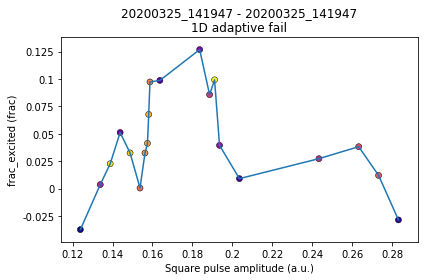

In [18]:
bounds = [0.7 * dummy_chevron.amp_center_2(), 1.6 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': adaptive.Learner1D,
    'bounds': bounds,
    'goal': lambda l: l.npoints >= npoints
    })

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D adaptive fail'
dat = MC.run(label, mode="adaptive")
ma2.Basic1DAnalysis(label=label, close_figs=False)

### Of course it is not bullet proof, poor choice of boundaries and noise might get into the way, but we can help it a bit

To achieve this we use tools that are available in `PycQED`.

NB: The tools (`loss` and `goal` making functions) in `pycqed.utilities.learner1D_minimizer` require the use of a modified verion of the learner: `pycqed.utilities.learner1D_minimizer.Learner1D_Minimizer`.

Other issues might arise and the `Learner1D_Minimizer` is flexible to be adjusted for other cases.

### We can impose minum sampling priority to segments with length below certain distance, i.e. force minimum resolution

Starting measurement: 1D adaptive segment size
Sweep function: amp
Detector function: frac_excited
Acquired 20 points, 	elapsed time: 3.1s

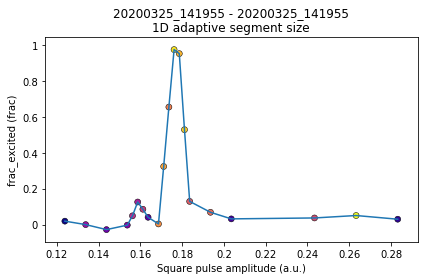

In [19]:
from adaptive.learner.learner1D import default_loss
from pycqed.utilities import learner1D_minimizer as l1dm
reload(l1dm)

dummy_chevron.delay(.0)

# Live plotting has a significant overhead, uncomment to see difference
# MC.live_plot_enabled(False)

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: l.npoints >= npoints,
    'loss_per_interval': l1dm.mk_res_loss_func(
        default_loss_func=default_loss,
        # do not split segments that are x3 smaller than uniform sampling
        min_distance=(bounds[-1] - bounds[0]) / npoints / 3)
    })

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D adaptive segment size'
dat = MC.run(label, mode="adaptive")
ma2.Basic1DAnalysis(label=label, close_figs=False)

### High resolution for reference of unerlying model (no noise)

Starting measurement: 1D uniform HR
Sweep function: amp
Detector function: frac_excited
 100% completed 	elapsed time: 6.7s 	time left: 0.0s
Starting measurement: 1D adaptive HR
Sweep function: amp
Detector function: frac_excited
Acquired 100 points, 	elapsed time: 14.9s

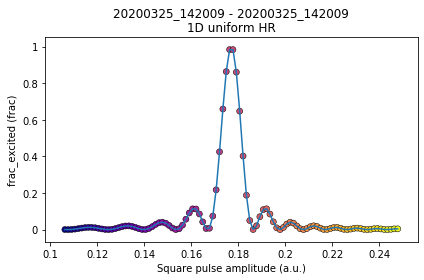

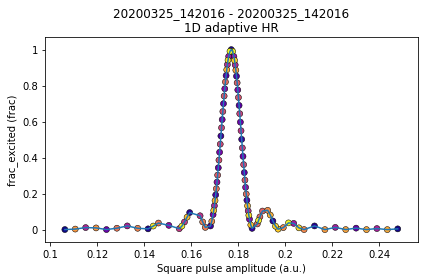

In [20]:
dummy_chevron.delay(.05)
dummy_chevron.noise(.0)
dummy_chevron.detuning_swt_spt(2 * np.pi * 2e9)

npoints = 100
bounds = [0.6 * dummy_chevron.amp_center_2(), 1.4 * dummy_chevron.amp_center_2()]

MC.soft_avg(1)
MC.set_sweep_function(dummy_chevron.amp)
MC.set_sweep_points(np.linspace(bounds[0], bounds[-1], npoints))

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D uniform HR'
dat = MC.run(label, mode="1D")
ma2.Basic1DAnalysis(label=label, close_figs=False)

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: l.npoints >= npoints,
    'loss_per_interval': l1dm.mk_res_loss_func(
        default_loss_func=default_loss,
        # do not split segments that are x3 smaller than uniform sampling
        min_distance=(bounds[-1] - bounds[0]) / npoints / 3)
    })

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D adaptive HR'
dat = MC.run(label, mode="adaptive")
ma2.Basic1DAnalysis(label=label, close_figs=False)

For more cool animations and other examples of adaptive sampling visit `adaptive` package [documentation]  and [tutorials].

[documentation]: https://adaptive.readthedocs.io/en/latest/docs.html#examples
[tutorials]: https://adaptive.readthedocs.io/en/latest/tutorial/tutorial.html

## **Problem:** How to maximize this noisy function?

For the 1D there are probably many decent solutions, but this serves as well to give some intuition for the N-dimensional generalization.

### Tip:
Many optimizers are minimizer by design or default. `MC` detects the `minimize: False` option when passed to `set_adaptive_function_parameters` so that any minimzer can be used as a maximizer.

### Meet the `SKOptLearner`
This is a wrapper included in the `adaptive` package that wraps around [scikit-optimize].

Interesting features include otimization over integers and Bayesian optimization (not based on gradients, therefore has some noise resilience), beside the N-dim capabilities.

NB: might not be appropriate for functions that are quick to evaluate as the model that it builds under the hood might be computationally expensive.

NB2: due to some probabilistic factors inside this learner + the noise in our functions it will take sitinct ammounts of iterations to get the maximum

**NB3:** From experience it might get stuck at the boundaries sometimes, configuration exploration might be required to make it work for your case

[scikit-optimize]: https://scikit-optimize.github.io/stable/

Starting measurement: 1D maximize skopt
Sweep function: amp
Detector function: frac_excited
Acquired 12 points, 	elapsed time: 9.2s


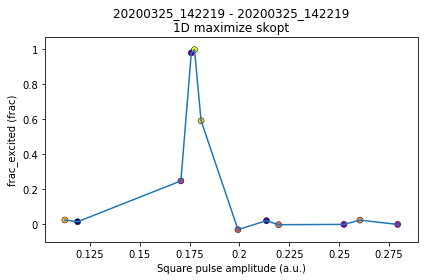

In [24]:
dummy_chevron.delay(.2)
dummy_chevron.noise(.05)

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.6 * dummy_chevron.amp_center_2()]
npoints = 30  # Just in case

target_f = 0.99

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': adaptive.SKOptLearner,
    # this one has its own paramters, might require exploring it
    'dimensions': [bounds],   
    'base_estimator': "GP", 
    'acq_func': "gp_hedge",
    'acq_optimizer': "lbfgs",
    'goal': lambda l: l.npoints >= npoints,
    'minimize': False,
    'f_termination': target_f,
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize skopt'
try:
    dat = MC.run(label, mode="adaptive")
except StopIteration as e:
    print(e)
ma2.Basic1DAnalysis(label=label, close_figs=False)

### Meet the home made `Learner1D_Minimizer` (and its tools)
###### (with blood, sweat and tears of master students)

Starting measurement: 1D maximize
Sweep function: amp
Detector function: frac_excited
Acquired 18 points, 	elapsed time: 13.3s

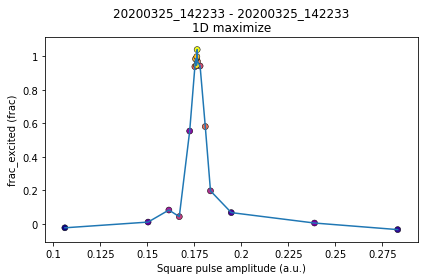

In [25]:
dummy_chevron.delay(.2)
dummy_chevron.noise(.05)

# If the optimal pnt is in the middle would be trivial to find the optimal pnt
bounds = [0.6 * dummy_chevron.amp_center_2(), 1.6 * dummy_chevron.amp_center_2()]
npoints = 40  # Just in case

loss = l1dm.mk_minimization_loss_func(max_no_improve_in_local=4)
goal = l1dm.mk_minimization_goal_func()

target_f = 0.999

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    # the modified learner requires the call of a dedicated goal function that takes care of certain things
    # goal(learner) returns always False so that it can be chained with the user goal
    # mind the sign! This can be easily lead to mistakes. The learner will get the inverse of our detector output
    'goal': lambda l: goal(l) or l.npoints >= npoints or l.last_min <= -target_f,
    'loss_per_interval': loss,
    'minimize': False,
    #'goal': lambda l: l.npoints >= npoints,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## **Problem:** What if I want to fit the peak and maximize the number of point on the peak?
This solution was developed for flux bias calibration through chevron alignment, see `pycqed.instrument_drivers.meta_instrument.device_object_CCL.measure_chevron_1D_bias_sweep`

Starting measurement: 1D maximize peak points for fit
Sweep function: amp
Detector function: frac_excited
Acquired 31 points, 	elapsed time: 20.9s

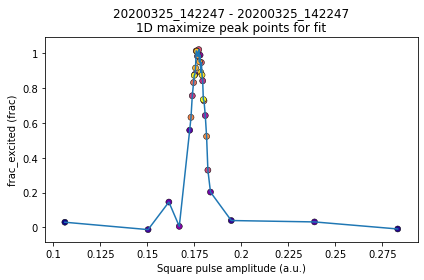

In [26]:
# We want a specific number point on the peak in order to fit
minimizer_threshold = 0.6
max_pnts_beyond_threshold = 20

# For this case there is a dedicated goal func
goal = l1dm.mk_min_threshold_goal_func(
    max_pnts_beyond_threshold=max_pnts_beyond_threshold
)
# and a specific option in the loss function
loss = l1dm.mk_minimization_loss_func(
    threshold=-minimizer_threshold)

adaptive_pars = {
    "adaptive_function": l1dm.Learner1D_Minimizer,
    "goal": lambda l: goal(l) or l.npoints > npoints,
    "bounds": bounds,
    "loss_per_interval": loss,
    "minimize": False,
}

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters(adaptive_pars)

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize peak points for fit'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## **Problem:** What if I know I am already in a local optimal and just want to converge?
Note that we are using a noisy model

Starting measurement: 1D maximize already in local
Sweep function: amp
Detector function: frac_excited
Acquired 40 points, 	elapsed time: 25.9s

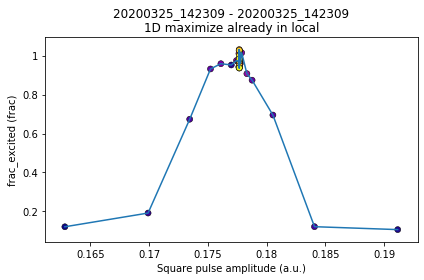

In [27]:
# Set the maximum sampling points budget
npoints = 40

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=4,
    converge_at_local=True)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.92 * dummy_chevron.amp_center_2(), 1.08 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize already in local'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## **Problem:** What if I want to converge to the first local optimal that is below a threshold?
Blindly converging in the local optimal might be an issue with noise or outliers, setting a threshold might be safer

Starting measurement: 1D maximize converge first local
Sweep function: amp
Detector function: frac_excited
Acquired 20 points, 	elapsed time: 14.6s

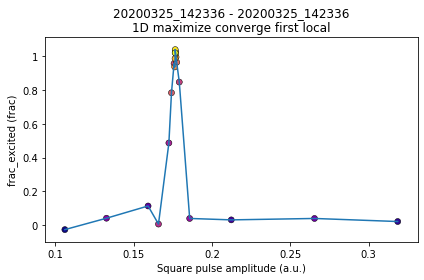

In [28]:
# Set the maximum sampling points budget
npoints = 20
target_f = 0.8

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=4,
    converge_below=-target_f)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize converge first local'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## **Problem:** What if I want to sample mostly optimal regions but also understand how the landscape?
Actually much of the logic of the `Learner1D_Minimizer` relies on the balance between sampling around the best optimal seen values and the size of the biggest segments on the landscapes.

Starting measurement: 1D maximize
Sweep function: amp
Detector function: frac_excited
Acquired 50 points, 	elapsed time: 31.1s

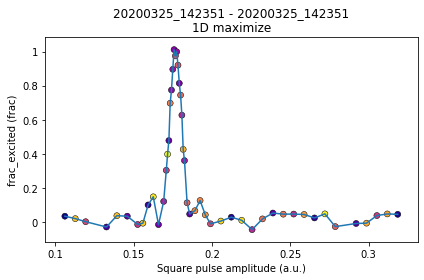

In [29]:
dummy_chevron.noise(.05)
npoints = 50
interval_weight = 100.

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=4,
    interval_weight=interval_weight)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

### `interval_weight` is knob that allows to control the bias towards large intervals vs intervals that share a point close to the best seen optimal

`interval_weight` was arbitrarily defined to take values in the range `[0., 1000.]`. You need to play a bit to get a feeling for what value your particluar case requires. The default should already give reasonable results.

`interval_weight=0.` sets maximum sampling priority on the intervals containing the best seen optimal point.

Starting measurement: 1D maximize
Sweep function: amp
Detector function: frac_excited
Acquired 50 points, 	elapsed time: 31.2s

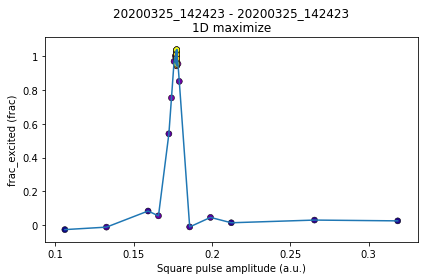

In [30]:
npoints = 50
interval_weight = 0.

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=4,
    interval_weight=interval_weight)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

`interval_weight=1000.` sets maximum priority to the largest interval, this translates into uniform sampling.

Starting measurement: 1D maximize
Sweep function: amp
Detector function: frac_excited
Acquired 50 points, 	elapsed time: 31.5s

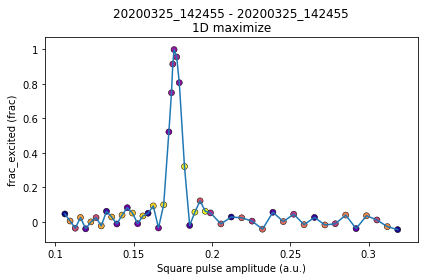

In [31]:
npoints = 50
interval_weight = 1000.
max_no_improve_in_local = 4

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=max_no_improve_in_local,
    interval_weight=interval_weight)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

### Note that it still found the global optimal
The bias between large intervals and optimal values is the strategy used to search for the global optimal. Every time it finds a new best optimal the corresponding intervals get maximum sampling priority, and that priority persists for `max_no_improve_in_local` new samples.

You may want to set `max_no_improve_in_local=2` to almost fully impose the uniform sampling, or you can increase it in order to make the sampler more persistent exploring the local optima.

Starting measurement: 1D maximize
Sweep function: amp
Detector function: frac_excited
Acquired 50 points, 	elapsed time: 31.6s

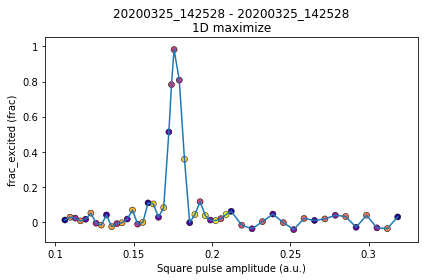

In [32]:
npoints = 50
interval_weight = 1000.
max_no_improve_in_local = 2

loss = l1dm.mk_minimization_loss_func(
    max_no_improve_in_local=max_no_improve_in_local,
    interval_weight=interval_weight)
goal = l1dm.mk_minimization_goal_func()

bounds = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

MC.set_sweep_function(dummy_chevron.amp)
MC.set_adaptive_function_parameters({
    'adaptive_function': l1dm.Learner1D_Minimizer,
    'bounds': bounds,
    'goal': lambda l: goal(l) or l.npoints >= npoints,
    'loss_per_interval': loss,
    'minimize': False,
    
})

MC.set_detector_function(dummy_chevron.frac_excited)
label = '1D maximize'
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## **Problem:** What if I would like to run two adaptive samplers with distinct setting in the same domain?
#### Use case: sample chevron on both sides (negative and positive amplitudes)
The distinct setting here are the boundaries that correspond to a small positive amplitude region and a small negative region. The basic way of achiving this is to run two distinct experiment, i.e. call `MC.run(...)` twice and end up with two files that need merging later.

There is a new `MC` feature that runs an outer loop of a list of adaptive samplers! Everthing is kept in the same dataset.

We could pontially run distinct types of adaptive sampler and/or optimizers in the same dataset, not tested yet though.

Starting measurement: 1D multi_adaptive_single_dset
Sweep function: amp
Detector function: frac_excited
Acquired 53 points, 	elapsed time: 36.4s

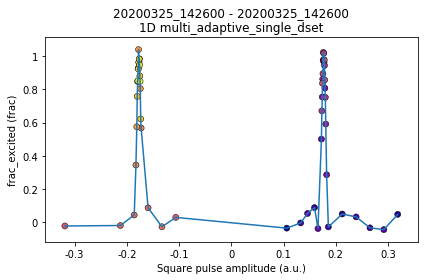

In [33]:
adaptive_sampling_pts = 50
max_no_improve_in_local = 4
max_pnts_beyond_threshold = 15

amps = [0.6 * dummy_chevron.amp_center_2(), 1.8 * dummy_chevron.amp_center_2()]

goal = l1dm.mk_min_threshold_goal_func(
    max_pnts_beyond_threshold=max_pnts_beyond_threshold)
loss = l1dm.mk_minimization_loss_func(
    threshold=-minimizer_threshold, interval_weight=100.0)

adaptive_pars_pos = {
    "adaptive_function": l1dm.Learner1D_Minimizer,
    "goal": lambda l: goal(l) or l.npoints > adaptive_sampling_pts,
    "bounds": amps,
    "loss_per_interval": loss,
    "minimize": False,
}

adaptive_pars_neg = {
    "adaptive_function": l1dm.Learner1D_Minimizer,
    "goal": lambda l: goal(l) or l.npoints > adaptive_sampling_pts,
    # NB: order of the bounds matters, mind negative numbers ordering
    "bounds": np.flip(-np.array(amps), 0),
    "loss_per_interval": loss,
    "minimize": False,
}

MC.set_sweep_function(dummy_chevron.amp)
adaptive_pars = {
    "multi_adaptive_single_dset": True,
    "adaptive_pars_list": [adaptive_pars_pos, adaptive_pars_neg],
}

MC.set_adaptive_function_parameters(adaptive_pars)
label = "1D multi_adaptive_single_dset"
dat = MC.run(label, mode="adaptive")

ma2.Basic1DAnalysis(label=label, close_figs=False)

## Get ready for the mind blow
## **Problem:** What if we want to do the same thing but also sweep linearly a few points in a second dimension
#### Example: sweep the flux bias so that it can be calibrated to align the chevrons

`MC` has an extra loop that allows for that as well!

It is being used in `pycqed.instrument_drivers.meta_instrument.device_object_CCL.measure_chevron_1D_bias_sweep`

Starting measurement: 1D multi_adaptive_single_dset extra_dims_sweep_pnts
Sweep function 0: amp
Sweep function 1: flux_bias
Detector function: frac_excited
Acquired 126 points, 	elapsed time: 73.5s

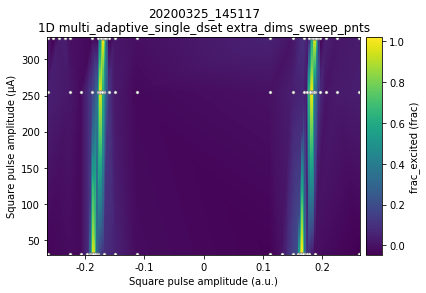

In [46]:
import warnings

dummy_chevron.delay(0.1)
MC.plotting_interval(1.)

adaptive_sampling_pts = 40
max_no_improve_in_local = 4
max_pnts_beyond_threshold = 10

amps = [0.6 * dummy_chevron.amp_center_2(), 1.4 * dummy_chevron.amp_center_2()]

goal = l1dm.mk_min_threshold_goal_func(
    max_pnts_beyond_threshold=max_pnts_beyond_threshold)
loss = l1dm.mk_minimization_loss_func(
    threshold=-minimizer_threshold, interval_weight=100.0)

adaptive_pars_pos = {
    "adaptive_function": l1dm.Learner1D_Minimizer,
    "goal": lambda l: goal(l) or l.npoints > adaptive_sampling_pts,
    "bounds": amps,
    "loss_per_interval": loss,
    "minimize": False,
}

adaptive_pars_neg = {
    "adaptive_function": l1dm.Learner1D_Minimizer,
    "goal": lambda l: goal(l) or l.npoints > adaptive_sampling_pts,
    # NB: order of the bounds matters, mind negative numbers ordering
    "bounds": np.flip(-np.array(amps), 0),
    "loss_per_interval": loss,
    "minimize": False,
}

flux_bias_par = dummy_chevron.flux_bias
mv_bias_by=[-150e-6, 150e-6, 75e-6]
flux_bias_par(180e-6)

# Mind that the order matter, linear sweeped pars at the end
MC.set_sweep_functions([dummy_chevron.amp, flux_bias_par])
adaptive_pars = {
    "multi_adaptive_single_dset": True,
    "adaptive_pars_list": [adaptive_pars_pos, adaptive_pars_neg],
    "extra_dims_sweep_pnts": flux_bias_par() + np.array(mv_bias_by),
}

MC.set_adaptive_function_parameters(adaptive_pars)
label = "1D multi_adaptive_single_dset extra_dims_sweep_pnts"

with warnings.catch_warnings():
    # ignore some warning, interpolations needs some extra features to support this mode
    warnings.simplefilter("ignore")
    dat = MC.run(label, mode="adaptive")

ma2.Basic2DInterpolatedAnalysis(label=label, close_figs=False)

## TODO

* [ ] 2D adaptive
* [ ] ND adaptive